# Determine Stage 8 End of Stage Logic

**Goal**: determine what/how animals in V2 of the Fixation Grower protocol will advance from stage 8 into the probe stages

**Context**: stage 8 is when the violation penalty turns on. I showed in the `assess_dms_gnp_data` notebook that this had a big effect on violation rates. when training DMS2 animals, I used violation rate < 20% as a metric for advancement. This is too circular given I want to use violation rate as a metric for experiment comparison. So, I want to find other metrics that can instead be used to move an animal out of this stage. 

**Ideas**:

* find a way to normalize violation rate 
    * day (day -1) before stage 8 is 0, best violation rate is 1 
* look at delta violation rates day to day as well as to best violation rate
* look at days to best violation rate


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 1. Data Wrangling

1. Load in Data
2. Make relative to starting stage 8 (include final days in stage 7)
3. Make columns (and plot each one first)

* `violation_rate`

* `violation_rate_delta_end_7`

* `violaton_rate_delta_yesterday`

* `violation_rate_relative`

In [64]:
save_name = "processed_df.csv"
save_path = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/analyses/fixation_experiment"

df = pd.read_csv(save_path + save_name)
df["date_time_date"] = pd.to_datetime(df["date_time_date"])
df = df.query("stage >=5 and stage <= 8 and session < 50").copy()

animals_to_drop = ["C214"]  # never got fixation due to concurrent spoke
df = df.query("animal_id not in @animals_to_drop").copy()

In [65]:
df.head()

,trial,animal_id,date,sess_id,hits,violations,stage,sa,sb,stimuli_on,...,sound_pair,give_type_imp,give_frac,n_settling_ins,avg_settling_in,cpoke_dur,date_time_date,session,cumulative_trial,fixation_dur
0,97,R010,2023-09-11,928485,1.0,0.0,5.0,12.0,12.0,False,...,"12.0, 12.0",light,1.0,NaN,NaN,NaN,2023-09-11,1,1,0.01000
1,98,R010,2023-09-11,928485,1.0,0.0,5.0,12.0,12.0,False,...,"12.0, 12.0",water_and_light,1.0,8.0,0.152029,0.4193,2023-09-11,1,2,0.40500
2,99,R010,2023-09-11,928485,1.0,0.0,5.0,3.0,3.0,False,...,"3.0, 3.0",water_and_light,1.0,2.0,0.257900,0.4442,2023-09-11,1,3,0.40500
3,1,R010,2023-09-12,928634,NaN,1.0,5.0,12.0,3.0,False,...,"12.0, 3.0",water_and_light,1.0,8.0,0.124114,0.7556,2023-09-12,2,4,0.43675
4,2,R010,2023-09-12,928634,0.0,0.0,5.0,3.0,12.0,False,...,"3.0, 12.0",water_and_light,1.0,4.0,0.193800,0.7024,2023-09-12,2,5,0.43675


### 1.1 Relative to Stage 8

In [66]:
# Find the minimum date where stage is 8 for each animal
min_date_stage_8 = (
    df.query("stage == 8").groupby("animal_id")["date_time_date"].min().reset_index()
)
min_date_stage_8.rename(columns={"date_time_date": "min_date_stage_8"}, inplace=True)

# Merge the minimum dates back into the original DataFrame
df = df.merge(min_date_stage_8, on="animal_id", how="left")

# Calculate days relative to the minimum date where stage is 8 for each animal
df["days_relative_to_8"] = (df["date_time_date"] - df["min_date_stage_8"]).dt.days

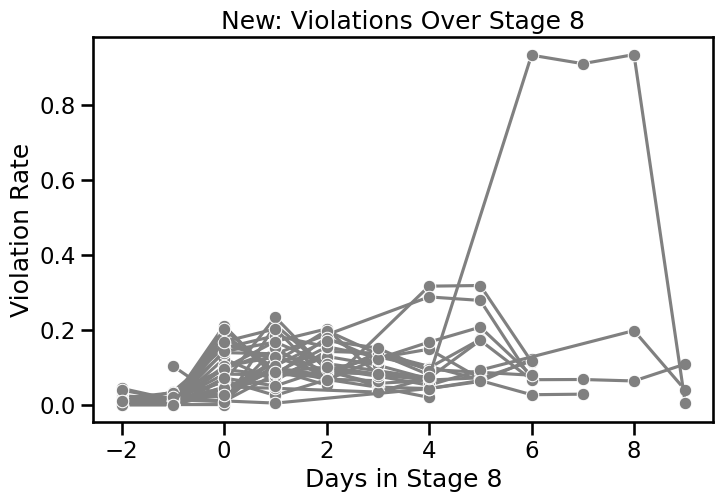

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))

plot_df = df.query("stage < 9 and days_relative_to_8 > -3 and days_relative_to_8 < 10")
sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y="violations",
    marker="o",
    palette=sns.color_palette(["gray"], n_colors=plot_df.animal_id.nunique()),
    hue="animal_id",
    ax=ax,
    errorbar=None,
    zorder=100,
)

_ = ax.set(
    xlabel="Days in Stage 8",
    ylabel="Violation Rate",
    title="New: Violations Over Stage 8",
)

ax.get_legend().remove()

Note R039 is the outlier with the large peak in violations on days 5-6-7

In [74]:
q = (
    plot_df.groupby(["animal_id", "days_relative_to_8"])["violations"]
    .mean()
    .reset_index()
)

q.max()

animal_id                 R039
days_relative_to_8           9
violations            0.933333
dtype: object

### 1.2 Violations pre stage 8 (proxy)

There are no violations in stage 7 due to the structure of the task. Here, we will use a proxy of multi-cpoke rate which is when nsettling ins > 1 if stage is less than 8.

In [61]:
df["multi_cpoke"] = df["n_settling_ins"] > 1

df["failed_fixation_rate"] = np.where(
    df["days_relative_to_8"] < 0,
    df["multi_cpoke"],
    df["violations"],
)

df["penalty_type"] = np.where(df["days_relative_to_8"] < 0, "none", "time out")

viol_df = (
    df.groupby(["animal_id", "days_relative_to_8"])
    .agg(
        {
            "failed_fixation_rate": "mean",
            "penalty_type": "first",  # Assuming penalty_type is consistent within each group
            "stage": "first",
        }
    )
    .reset_index()
)

In [62]:
viol_df.head()

,animal_id,days_relative_to_8,failed_fixation_rate,penalty_type,stage
0,C214,-17,0.416667,none,5.0
1,C214,-16,0.526316,none,5.0
2,C214,-15,0.347826,none,5.0
3,C214,-14,0.570652,none,5.0
4,C214,-13,0.883333,none,5.0


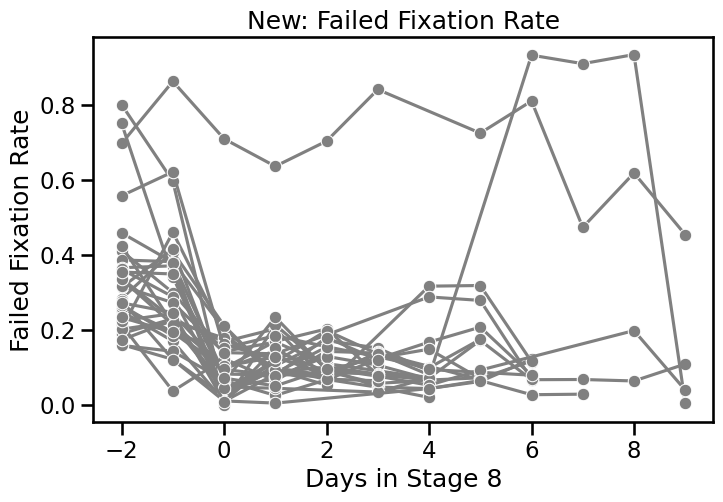

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

plot_df = viol_df.query(
    "stage < 9 and days_relative_to_8 > -3 and days_relative_to_8 < 10"
)
sns.lineplot(
    data=plot_df,
    x="days_relative_to_8",
    y="failed_fixation_rate",
    marker="o",
    palette=sns.color_palette(["gray"], n_colors=plot_df.animal_id.nunique()),
    hue="animal_id",
    ax=ax,
    errorbar=None,
    zorder=100,
)

_ = ax.set(
    xlabel="Days in Stage 8",
    ylabel="Failed Fixation Rate",
    title="New: Failed Fixation Rate",
)

ax.get_legend().remove()

### 1.3 Violation rate relative to 1 days prior to stage 8 start

Turn this into a flexible function so number of days can change and so that the column can easily be made and appended to a data frame